In [ ]:
# !pip install kaggle

# Download Dataset dari Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 99% 1.16G/1.17G [00:07<00:00, 187MB/s]
100% 1.17G/1.17G [00:07<00:00, 173MB/s]


In [ ]:
!unzip -q /content/labeled-chest-xray-images.zip -d images

# Import Library

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Pengecekan Dataa

In [ ]:
os.listdir('/content/images/chest_xray')

['test', 'train']

In [ ]:
print('jumlah normal:', len(os.listdir('/content/images/chest_xray/train/NORMAL')))
print('jumlah pneumonia:', len(os.listdir('/content/images/chest_xray/train/PNEUMONIA')))

jumlah normal: 1349
jumlah pneumonia: 3883


cek gambar yang normal


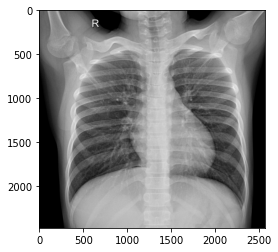

In [ ]:
print('cek gambar yang normal')
plt.imshow(cv2.imread('/content/images/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg'))

cek gambar yang pneumonia


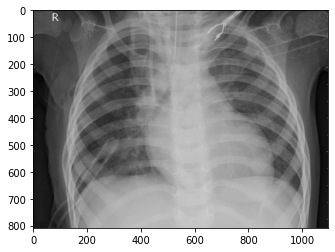

In [ ]:
print('cek gambar yang pneumonia')
plt.imshow(cv2.imread('/content/images/chest_xray/train/PNEUMONIA/BACTERIA-1025587-0001.jpeg'))

# Data Augmentation

In [ ]:
img_size= 240
batch= 64

In [ ]:
train_datagen= ImageDataGenerator(rescale=1./255,
                                  shear_range= 0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

ds_train= train_datagen.flow_from_directory(directory='/content/images/chest_xray/train',
                                            target_size= (img_size,img_size),
                                            batch_size=batch,
                                            class_mode='binary')

ds_val= val_datagen.flow_from_directory(directory='/content/images/chest_xray/test',
                                            target_size= (img_size,img_size),
                                            batch_size=batch,
                                            class_mode='binary')

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
ds_train.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Pembuatan Model

In [ ]:
callbacks1 = [
              callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1),
              callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2, verbose=1)
]

In [ ]:
inputs= [img_size,img_size,3]

my_model= Sequential()

#CNN
my_model.add(layers.Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
my_model.add(layers.MaxPool2D(pool_size=2, strides=2))

my_model.add(layers.Conv2D(filters=32, kernel_size=3, activation= 'relu'))
my_model.add(layers.MaxPool2D(pool_size=2, strides=2))

my_model.add(layers.Conv2D(filters=64, kernel_size=3, activation= 'relu'))
my_model.add(layers.MaxPool2D(pool_size=2, strides=2))

my_model.add(layers.Flatten())
my_model.add(layers.Dense(units= 128, activation='relu'))
my_model.add(layers.Dense(units=1, activation='sigmoid'))

my_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history= my_model.fit(ds_train,
                      batch_size=batch, epochs=5,
                      validation_data= ds_val,
                      callbacks=callbacks1,
                      steps_per_epoch= (5232/batch),
                      validation_steps= (624/batch));

Epoch 1/5
81/81 [==============================] - 204s 2s/step - loss: 0.4607 - accuracy: 0.8037 - val_loss: 0.3070 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 2/5
81/81 [==============================] - 136s 2s/step - loss: 0.2260 - accuracy: 0.9098 - val_loss: 0.2695 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 3/5
81/81 [==============================] - 133s 2s/step - loss: 0.2166 - accuracy: 0.9134 - val_loss: 0.1998 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 4/5
81/81 [==============================] - 135s 2s/step - loss: 0.1656 - accuracy: 0.9299 - val_loss: 0.2166 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 5/5
81/81 [==============================] - 135s 2s/step - loss: 0.1769 - accuracy: 0.9316 - val_loss: 0.1937 - val_accuracy: 0.9215 - lr: 0.0010


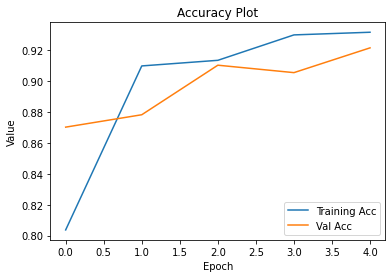

In [ ]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

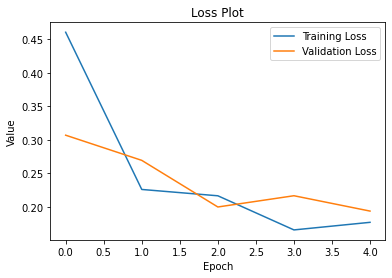

In [ ]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

# Uji Coba

Saving covid_tes.jpg to covid_tes.jpg


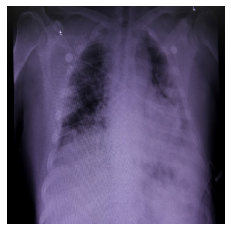

[[1.]]
pneumonia


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(240,240))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = my_model.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] == 1:
    print('pneumonia')
  else:
    print('normal')